<a href="https://colab.research.google.com/github/kanishka-006/traffic-forecasting-using-graph-neural-network/blob/main/traffic_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch-scatter -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-sparse -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-cluster -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-${pt_version}.html
!pip install torch-geometric
!pip install torch-geometric-temporal


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-.html
  Using cached torch_sparse-0.6.14.tar.gz (51 kB)
  Created wheel for torch-sparse: filename=torch_sparse-0.6.14-cp37-cp37m-linux_x86_64.whl size=497879 sha256=6b034c6c7aa4e94f47d94463b769343320e739fd417c50336f59d33270239a58
  Stored in directory: /root/.cache/pip/wheels/3c/aa/62/db0259eae2abce84f1ee2cf1c531bba683aab4bf79054172f8
Successfully built torch-sparse
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://pytorch-geometric.com/whl/torch-.html
     |████████████████████████████████| 43 kB 960 kB/s 
  Created wheel for torch-cluster: filename=torch_cluster-1.6.0-cp37-cp37m-linux_x86_64.whl

In [ ]:
import torch
from IPython.display import clear_output
pt_version = torch.__version__
print(pt_version)

1.12.1+cu113


Dataset
Traffic forecasting dataset based on Los Angeles Metropolitan traffic
207 loop detectors on highways
March 2012 - June 2012

In [ ]:
from torch_geometric_temporal.dataset import METRLADatasetLoader
loader = METRLADatasetLoader()
dataset = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=12)
print("Dataset type:  ", dataset)
print("Number of samples / sequences: ",  len(set(dataset)))

Dataset type:   <torch_geometric_temporal.signal.static_graph_temporal_signal.StaticGraphTemporalSignal object at 0x7ff7988627d0>
Number of samples / sequences:  34249


Data Sample
207 nodes
2 features per node (speed, time)
12 timesteps per bucket (12 x 5 min = 60 min)
Labels for 12 future timesteps (normalized speed) --> node regression
Edge_attr is build based on the distances between sensors + threshold

In [ ]:
# Show first sample
next(iter(dataset))

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [ ]:
from torch_geometric_temporal.dataset import ChickenpoxDatasetLoader
d = ChickenpoxDatasetLoader().get_dataset(lags=4)
next(iter(d))

Data(x=[20, 4], edge_index=[2, 102], edge_attr=[102], y=[20])

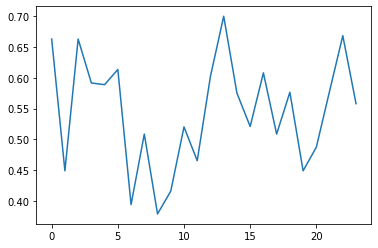

In [ ]:
import seaborn as sns
# Visualize traffic over time
sensor_number = 1
hours = 24
sensor_labels = [bucket.y[sensor_number][0].item() for bucket in list(dataset)[:hours]]
sns.lineplot(data=sensor_labels)

Test Train Split

In [ ]:
from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

print("Number of train buckets: ", len(set(train_dataset)))
print("Number of test buckets: ", len(set(test_dataset)))

Number of train buckets:  27399
Number of test buckets:  6850


Model
Which model to choose depends on which time-series task you work on.

A3TGCN is an extension of TGCN that uses attention
The spatial aggregation uses GCN, the temporal aggregation a GRU
We can pass in periods to get an embedding for several timesteps
This embedding can be used to predict several steps into the future = output dimension
We could also do this in a loop and feed it again into the model (would be autoregressive)
There is only one block here. Other layers also allow stacking???

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=32, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=2, periods=12)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)

Training
Training on GPU didn't bring much speed-up
I ran into RAM issues, why I only train on a smaller subset of the data

In [ ]:
# GPU support
device = torch.device('cpu') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=2, periods=12).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(10): 
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2) 
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
Epoch 0 train MSE: 0.7500
Epoch 1 train MSE: 0.7305
Epoch 2 train MSE: 0.7108
Epoch 3 train MSE: 0.6886
Epoch 4 train MSE: 0.6640
Epoch 5 train MSE: 0.6378
Epoch 6 train MSE: 0.6119
Epoch 7 train MSE: 0.5886
Epoch 8 train MSE: 0.5693
Epoch 9 train MSE: 0.5542


Evaluation
Lets get some sample predictions for a specific horizon (e.g. 288/12 = 24 hours)
The model always gets one hour and needs to predict the next hour

In [ ]:
model.eval()
loss = 0
step = 0
horizon = 288

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

Test MSE: 0.6775


Visualization
The further away the point in time is, the worse the predictions get
Predictions shape: [num_data_points, num_sensors, num_timesteps]

In [ ]:
import numpy as np

sensor = 123
timestep = 11 
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])
print("Data points:,", preds.shape)

Data points:, (289,)


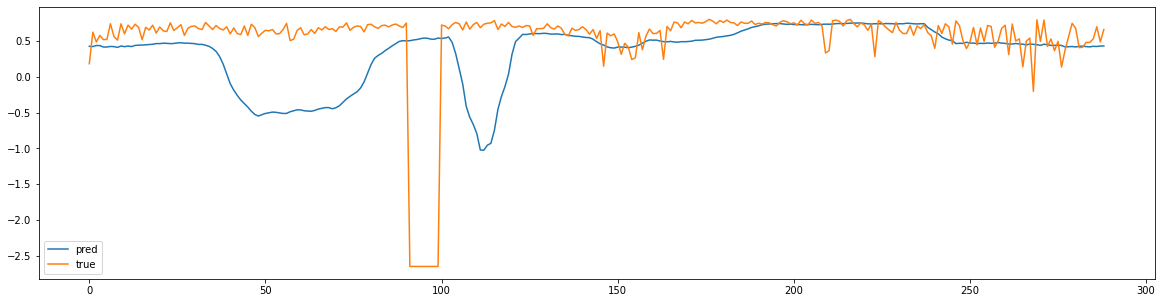

In [ ]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")